In [80]:
import os
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt

# 📡 Conexión a Snowflake
conn = snowflake.connector.connect(
    account=os.getenv("SF_ACCOUNT"),
    user=os.getenv("SF_USER"),
    password=os.getenv("SF_PASSWORD"),
    warehouse=os.getenv("SF_WAREHOUSE"),
    database=os.getenv("SF_DATABASE"),
    schema="ANALYTICS",  # OBT está aquí
    role=os.getenv("SF_ROLE"),
)


In [16]:
# a Top 10 zonas de pickup por volumen mensual. Caso 1 (zonas repetidas)
query = """
SELECT
    PU_ZONE,
    PU_BOROUGH,
    YEAR,
    MONTH,
    COUNT(*) AS TOTAL_TRIPS,
    ROW_NUMBER() OVER (
        ORDER BY COUNT(*) DESC
    ) AS GLOBAL_RANK
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025  -- Opcional: filtrar fechas válidas
GROUP BY PU_ZONE, PU_BOROUGH, YEAR, MONTH
ORDER BY TOTAL_TRIPS DESC
LIMIT 10;
"""

df_global_top10 = pd.read_sql(query, conn)
display(df_global_top10)



/tmp/ipykernel_63114/3502466470.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global_top10 = pd.read_sql(query, conn)


,PU_ZONE,PU_BOROUGH,YEAR,MONTH,TOTAL_TRIPS,GLOBAL_RANK
0,Upper East Side South,Manhattan,2015,4,497703,1
1,Upper East Side South,Manhattan,2015,5,484637,2
2,Upper East Side South,Manhattan,2015,3,473444,3
3,Upper East Side South,Manhattan,2015,10,468467,4
4,Upper East Side South,Manhattan,2016,5,465264,5
5,Midtown Center,Manhattan,2015,3,464162,6
6,Midtown Center,Manhattan,2015,4,460933,7
7,Upper East Side North,Manhattan,2015,4,458050,8
8,Midtown Center,Manhattan,2016,3,457857,9
9,Upper East Side South,Manhattan,2015,6,454707,10


In [19]:
# a) Top 10 zonas de pickup por volumen mensual. Caso 2 (zonas no repetidas)
query = """
WITH zone_max_month AS (
    SELECT
        PU_ZONE,
        PU_BOROUGH,
        YEAR,
        MONTH,
        COUNT(*) AS TOTAL_TRIPS,
        ROW_NUMBER() OVER (
            PARTITION BY PU_ZONE
            ORDER BY COUNT(*) DESC
        ) AS best_month_rank
    FROM ANALYTICS.OBT_TRIPS
    WHERE YEAR BETWEEN 2015 AND 2025
    GROUP BY PU_ZONE, PU_BOROUGH, YEAR, MONTH
)
SELECT
    PU_ZONE,
    PU_BOROUGH,
    YEAR,
    MONTH,
    TOTAL_TRIPS,
    ROW_NUMBER() OVER (
        ORDER BY TOTAL_TRIPS DESC
    ) AS GLOBAL_RANK
FROM zone_max_month
WHERE best_month_rank = 1      -- Solo el mejor mes de cada zona
ORDER BY TOTAL_TRIPS DESC
LIMIT 10;
"""

df_global_top10_unique = pd.read_sql(query, conn)
display(df_global_top10_unique)


/tmp/ipykernel_63114/1367849121.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global_top10_unique = pd.read_sql(query, conn)


,PU_ZONE,PU_BOROUGH,YEAR,MONTH,TOTAL_TRIPS,GLOBAL_RANK
0,Upper East Side South,Manhattan,2015,4,497703,1
1,Midtown Center,Manhattan,2015,3,464162,2
2,Upper East Side North,Manhattan,2015,4,458050,3
3,Times Sq/Theatre District,Manhattan,2015,3,442047,4
4,Midtown East,Manhattan,2015,3,441582,5
5,Murray Hill,Manhattan,2015,3,440112,6
6,East Village,Manhattan,2015,3,439620,7
7,Union Sq,Manhattan,2015,3,431348,8
8,Penn Station/Madison Sq West,Manhattan,2015,3,424726,9
9,Clinton East,Manhattan,2015,3,417905,10


In [18]:
#b. Top 10 zonas de dropoff por volumen mensual. Caso 1 (zonas repetidas permitidas)
query = """
SELECT
    DO_ZONE,
    DO_BOROUGH,
    YEAR,
    MONTH,
    COUNT(*) AS TOTAL_TRIPS,
    ROW_NUMBER() OVER (
        ORDER BY COUNT(*) DESC
    ) AS GLOBAL_RANK
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025  -- opcional: excluye fechas erróneas
GROUP BY DO_ZONE, DO_BOROUGH, YEAR, MONTH
ORDER BY TOTAL_TRIPS DESC
LIMIT 10;
"""

df_global_dropoff_top10 = pd.read_sql(query, conn)
display(df_global_dropoff_top10)


/tmp/ipykernel_63114/1408130018.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global_dropoff_top10 = pd.read_sql(query, conn)


,DO_ZONE,DO_BOROUGH,YEAR,MONTH,TOTAL_TRIPS,GLOBAL_RANK
0,Midtown Center,Manhattan,2015,3,506987,1
1,Midtown Center,Manhattan,2015,4,502432,2
2,Midtown Center,Manhattan,2015,5,480660,3
3,Midtown Center,Manhattan,2015,6,475216,4
4,Upper East Side North,Manhattan,2015,4,468671,5
5,Midtown Center,Manhattan,2016,3,467864,6
6,Upper East Side North,Manhattan,2015,5,464786,7
7,Midtown Center,Manhattan,2015,7,464059,8
8,Midtown Center,Manhattan,2015,2,462245,9
9,Midtown Center,Manhattan,2015,10,458148,10


In [20]:
#b. Top 10 zonas de dropoff por volumen mensual. Caso 2 (zonas duplicadas no permitidas)

query = """
WITH zone_max_month AS (
    SELECT
        DO_ZONE,
        DO_BOROUGH,
        YEAR,
        MONTH,
        COUNT(*) AS TOTAL_TRIPS,
        ROW_NUMBER() OVER (
            PARTITION BY DO_ZONE
            ORDER BY COUNT(*) DESC
        ) AS best_month_rank
    FROM ANALYTICS.OBT_TRIPS
    WHERE YEAR BETWEEN 2015 AND 2025
    GROUP BY DO_ZONE, DO_BOROUGH, YEAR, MONTH
)
SELECT
    DO_ZONE,
    DO_BOROUGH,
    YEAR,
    MONTH,
    TOTAL_TRIPS,
    ROW_NUMBER() OVER (
        ORDER BY TOTAL_TRIPS DESC
    ) AS GLOBAL_RANK
FROM zone_max_month
WHERE best_month_rank = 1      -- Solo el mejor mes por zona
ORDER BY TOTAL_TRIPS DESC
LIMIT 10;
"""

df_global_dropoff_top10_unique = pd.read_sql(query, conn)
display(df_global_dropoff_top10_unique)


/tmp/ipykernel_63114/3977556372.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global_dropoff_top10_unique = pd.read_sql(query, conn)


,DO_ZONE,DO_BOROUGH,YEAR,MONTH,TOTAL_TRIPS,GLOBAL_RANK
0,Midtown Center,Manhattan,2015,3,506987,1
1,Upper East Side North,Manhattan,2015,4,468671,2
2,Upper East Side South,Manhattan,2015,4,440255,3
3,Murray Hill,Manhattan,2015,3,431839,4
4,Times Sq/Theatre District,Manhattan,2015,3,423468,5
5,Midtown East,Manhattan,2015,3,406537,6
6,Union Sq,Manhattan,2015,3,383288,7
7,Penn Station/Madison Sq West,Manhattan,2015,3,364131,8
8,Clinton East,Manhattan,2015,3,358657,9
9,East Village,Manhattan,2015,3,358584,10


In [29]:
# c. Evolución mensual de total_amount y tip_pct por borough.

query = """
SELECT
    YEAR,
    MONTH,
    PU_BOROUGH AS BOROUGH,

    -- 💵 Ingreso total mensual por borough
    SUM(TOTAL_AMOUNT) AS TOTAL_REVENUE,

    -- 💚 Propina promedio (porcentaje sobre fare)
    AVG(
        CASE
            WHEN FARE_AMOUNT > 0 THEN (TIP_AMOUNT / FARE_AMOUNT) * 100
            ELSE NULL
        END
    ) AS AVG_TIP_PCT

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY YEAR, MONTH, PU_BOROUGH
ORDER BY YEAR, MONTH, BOROUGH;
"""

df_borough_evolution = pd.read_sql(query, conn)
display(df_borough_evolution.head(20))


/tmp/ipykernel_63114/2706178854.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_borough_evolution = pd.read_sql(query, conn)


,YEAR,MONTH,BOROUGH,TOTAL_REVENUE,AVG_TIP_PCT
0,2015,1,Bronx,1.150964e+06,4.812367
1,2015,1,Brooklyn,8.845167e+06,12.610327
2,2015,1,EWR,2.426130e+03,77.980124
3,2015,1,Manhattan,6.684405e+06,8.189843
4,2015,1,N/A,3.930015e+04,208.524446
5,2015,1,Queens,5.506409e+06,8.034693
6,2015,1,Staten Island,5.808180e+03,697.567959
7,2015,1,Unknown,6.173624e+04,320.701549
8,2015,2,Bronx,1.740683e+06,3.404012
9,2015,2,Brooklyn,1.353631e+07,13.537111


   YEAR  MONTH    BOROUGH  TOTAL_REVENUE  AVG_TIP_PCT       DATE
0  2015      1      Bronx     1150964.21     4.812367 2015-01-01
1  2015      1   Brooklyn     8845166.73    12.610327 2015-01-01
2  2015      1        EWR        2426.13    77.980124 2015-01-01
3  2015      1  Manhattan     6684404.78     8.189843 2015-01-01
4  2015      1        N/A       39300.15   208.524446 2015-01-01


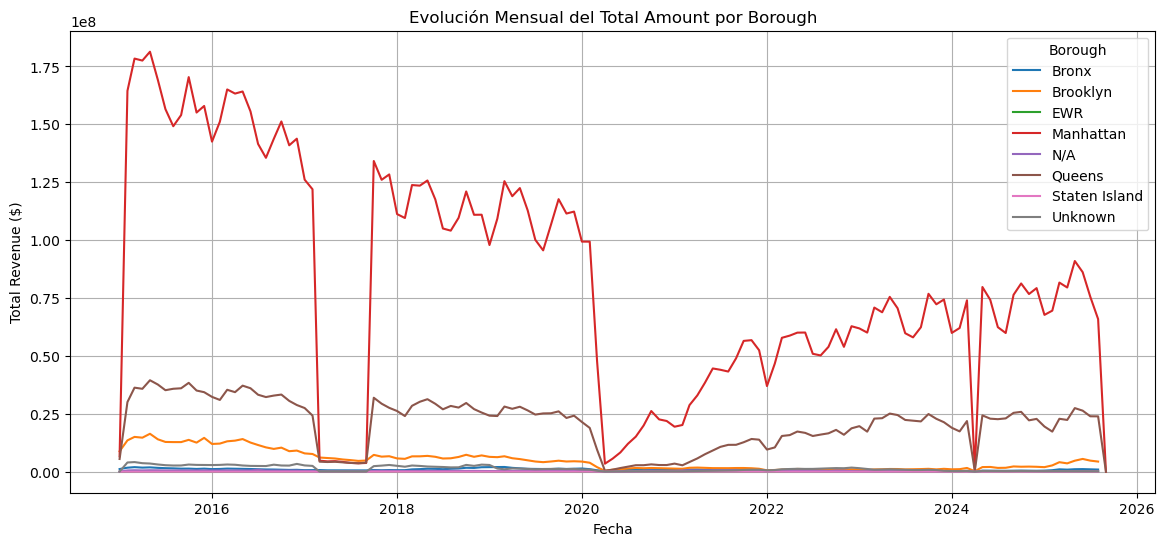

In [30]:
#c. grafico para ver la evolucion mensual de total amount
import pandas as pd
import matplotlib.pyplot as plt

# Crear columna fecha para eje X (YYYY-MM)
df_borough_evolution['DATE'] = pd.to_datetime(
    df_borough_evolution['YEAR'].astype(str) + '-' +
    df_borough_evolution['MONTH'].astype(str) + '-01'
)

print(df_borough_evolution.head())

plt.figure(figsize=(14,6))
for borough in df_borough_evolution['BOROUGH'].unique():
    subset = df_borough_evolution[df_borough_evolution['BOROUGH'] == borough]
    plt.plot(subset['DATE'], subset['TOTAL_REVENUE'], label=borough)

plt.title("Evolución Mensual del Total Amount por Borough")
plt.xlabel("Fecha")
plt.ylabel("Total Revenue ($)")
plt.legend(title="Borough")
plt.grid(True)
plt.show()

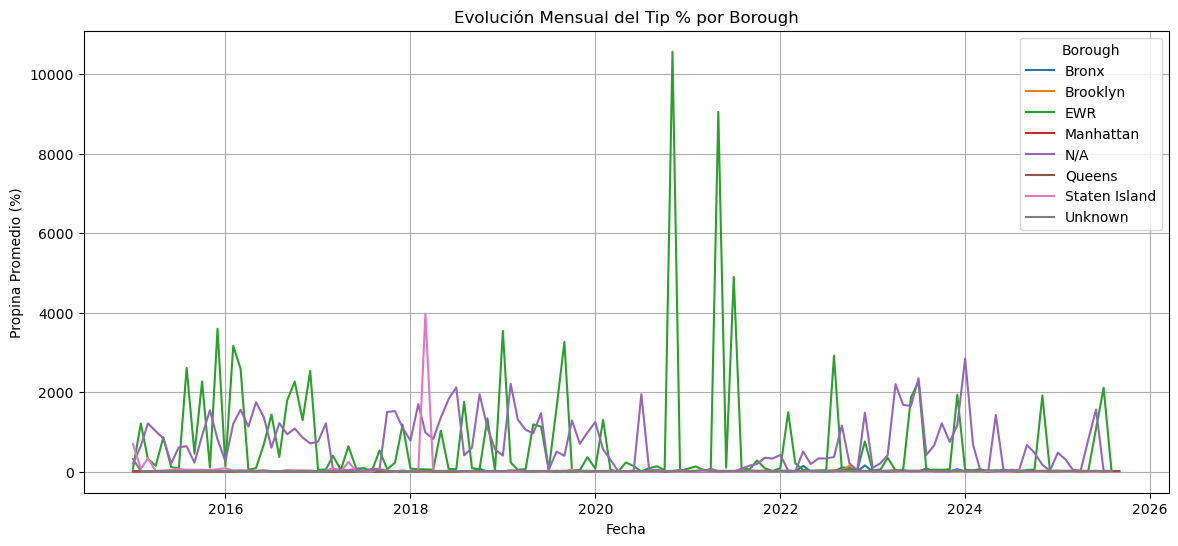

In [31]:
#c. grafico para ver la evolucion mensual de tip
plt.figure(figsize=(14,6))
for borough in df_borough_evolution['BOROUGH'].unique():
    subset = df_borough_evolution[df_borough_evolution['BOROUGH'] == borough]
    plt.plot(subset['DATE'], subset['AVG_TIP_PCT'], label=borough)

plt.title("Evolución Mensual del Tip % por Borough")
plt.xlabel("Fecha")
plt.ylabel("Propina Promedio (%)")
plt.legend(title="Borough")
plt.grid(True)
plt.show()


In [32]:
# d. Ticket promedio (avg total_amount) por service_type y mes. 
query = """
SELECT
    YEAR,
    MONTH,
    SERVICE_TYPE,
    AVG(TOTAL_AMOUNT) AS AVG_TICKET
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY YEAR, MONTH, SERVICE_TYPE
ORDER BY YEAR, MONTH, SERVICE_TYPE;
"""

df_avg_ticket = pd.read_sql(query, conn)
display(df_avg_ticket.head(20))


/tmp/ipykernel_63114/3401032665.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_ticket = pd.read_sql(query, conn)


,YEAR,MONTH,SERVICE_TYPE,AVG_TICKET
0,2015,1,GREEN,14.780456
1,2015,2,GREEN,14.490028
2,2015,2,YELLOW,15.400438
3,2015,3,GREEN,14.576802
4,2015,3,YELLOW,15.849297
5,2015,4,GREEN,14.814617
6,2015,4,YELLOW,16.035905
7,2015,5,GREEN,15.250106
8,2015,5,YELLOW,16.426353
9,2015,6,GREEN,14.958572


/tmp/ipykernel_63114/3620839060.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_peak_hours = pd.read_sql(query, conn)


✅ Datos cargados: (168, 3)
  DAY_OF_WEEK  HOUR_OF_DAY  TRIP_COUNT
0         Fri            0     3975812
1         Fri            1     2521648
2         Fri            2     1607438
3         Fri            3     1066599
4         Fri            4      908092


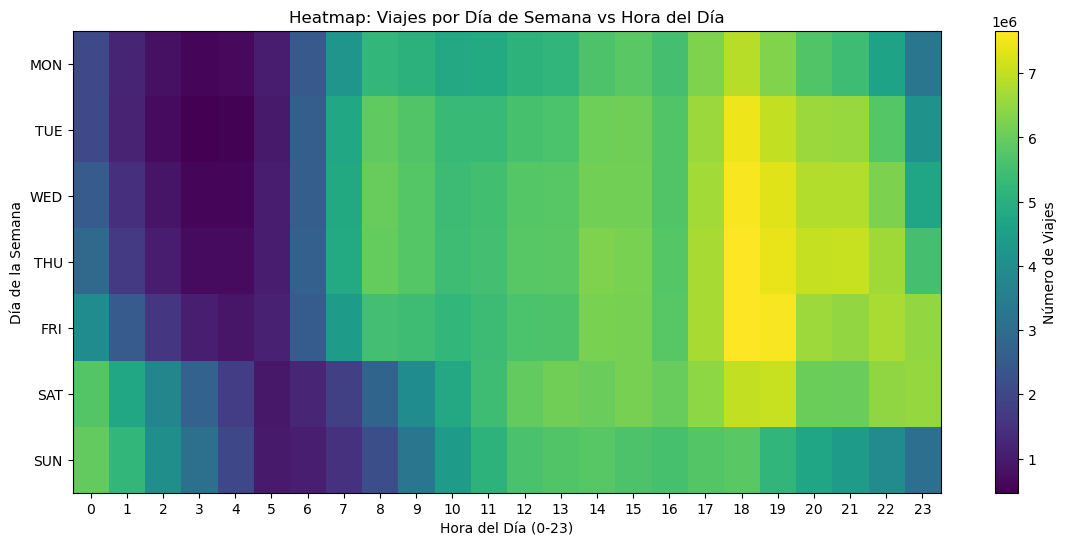

In [45]:
#e. Viajes por hora del día y día de semana (picos). 
query = """
SELECT
    TO_CHAR(pickup_datetime, 'DY') AS DAY_OF_WEEK,
    DATE_PART('HOUR', pickup_datetime) AS HOUR_OF_DAY,
    COUNT(*) AS TRIP_COUNT
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY 
    TO_CHAR(pickup_datetime, 'DY'),
    DATE_PART('HOUR', pickup_datetime)
ORDER BY 
    DAY_OF_WEEK, 
    HOUR_OF_DAY;
"""

df_peak_hours = pd.read_sql(query, conn)

# 2️⃣ Validar si hay datos
if df_peak_hours.empty:
    print("⚠️ No se recuperaron datos. Revisa YEAR/MONTH o dataset.")
else:
    print("✅ Datos cargados:", df_peak_hours.shape)
    print(df_peak_hours.head())

# 3️⃣ Normalizar día de semana a orden correcto
day_order = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
df_peak_hours['DAY_OF_WEEK'] = df_peak_hours['DAY_OF_WEEK'].str.upper().str.strip()
df_peak_hours['DAY_OF_WEEK'] = pd.Categorical(df_peak_hours['DAY_OF_WEEK'], categories=day_order, ordered=True)

# 4️⃣ Pivot table para heatmap
heatmap_data = df_peak_hours.pivot_table(
    index='DAY_OF_WEEK',
    columns='HOUR_OF_DAY',
    values='TRIP_COUNT',
    fill_value=0
)

# 5️⃣ Dibujar Heatmap
plt.figure(figsize=(14,6))
plt.imshow(heatmap_data, aspect='auto')
plt.colorbar(label='Número de Viajes')
plt.title("Heatmap: Viajes por Día de Semana vs Hora del Día")
plt.xlabel("Hora del Día (0-23)")
plt.ylabel("Día de la Semana")

plt.xticks(range(24), range(24))
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

plt.show()



In [47]:
#e. Viajes por hora del día y día de semana (picos). 
query = """
SELECT
    DATE_PART('HOUR', pickup_datetime) AS HOUR_OF_DAY,
    COUNT(*) AS TOTAL_TRIPS
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY DATE_PART('HOUR', pickup_datetime)
ORDER BY TOTAL_TRIPS DESC
LIMIT 10;
"""

df_top_hours = pd.read_sql(query, conn)
display(df_top_hours)


/tmp/ipykernel_63114/2529805912.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_hours = pd.read_sql(query, conn)


,HOUR_OF_DAY,TOTAL_TRIPS
0,18,50077837
1,19,47864856
2,17,45190232
3,20,43519870
4,21,42857785
5,15,42259799
6,14,42186711
7,22,40417831
8,16,40108054
9,13,39915438


In [49]:
#f. p50/p90 de trip_duration_min por borough de pickup.
query = """
SELECT
    PU_BOROUGH AS BOROUGH,
    
    -- P50 (Mediana)
    APPROX_PERCENTILE(trip_duration_min, 0.5) AS P50_DURATION,
    
    -- P90 (percentil 90)
    APPROX_PERCENTILE(trip_duration_min, 0.9) AS P90_DURATION

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY PU_BOROUGH
ORDER BY P50_DURATION;
"""

df_duration_percentiles = pd.read_sql(query, conn)
display(df_duration_percentiles)


/tmp/ipykernel_63114/2994425135.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_duration_percentiles = pd.read_sql(query, conn)


,BOROUGH,P50_DURATION,P90_DURATION
0,EWR,0.000000,2.0
1,N/A,1.000000,60.0
2,Unknown,10.975578,28.0
3,Manhattan,11.000000,25.0
4,Brooklyn,13.000000,33.0
5,Bronx,13.244216,38.0
6,Staten Island,23.993762,71.0
7,Queens,24.000000,54.0


In [52]:
#g. avg_speed_mph por franja horaria (6–9, 17–20) y borough. 

query = """
WITH valid_trips AS (
    SELECT
        PU_BOROUGH,
        pickup_datetime,
        trip_duration_min,
        trip_distance,
        (trip_distance / (trip_duration_min / 60)) AS speed_mph
    FROM ANALYTICS.OBT_TRIPS
    WHERE 
        trip_duration_min > 1               -- duraciones válidas
        AND trip_duration_min < 180         -- menos de 3h
        AND trip_distance > 0.1             -- distancia positiva
        AND (trip_distance / (trip_duration_min / 60)) < 85  -- < 85 mph
)
SELECT
    PU_BOROUGH AS BOROUGH,
    CASE
        WHEN DATE_PART('HOUR', pickup_datetime) BETWEEN 6 AND 9  THEN 'Morning Peak (6-9)'
        WHEN DATE_PART('HOUR', pickup_datetime) BETWEEN 17 AND 20 THEN 'Evening Peak (17-20)'
    END AS TIME_WINDOW,
    AVG(speed_mph) AS AVG_SPEED_MPH
FROM valid_trips
WHERE DATE_PART('HOUR', pickup_datetime) IN (6,7,8,9,17,18,19,20)
GROUP BY BOROUGH, TIME_WINDOW
ORDER BY BOROUGH, TIME_WINDOW;
"""

df_speed_clean = pd.read_sql(query, conn)
display(df_speed_clean)


/tmp/ipykernel_63114/2347080857.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_speed_clean = pd.read_sql(query, conn)


,BOROUGH,TIME_WINDOW,AVG_SPEED_MPH
0,Bronx,Evening Peak (17-20),13.046795
1,Bronx,Morning Peak (6-9),14.429150
2,Brooklyn,Evening Peak (17-20),11.350631
3,Brooklyn,Morning Peak (6-9),13.258930
4,EWR,Evening Peak (17-20),22.036847
5,EWR,Morning Peak (6-9),23.714381
6,Manhattan,Evening Peak (17-20),10.013497
7,Manhattan,Morning Peak (6-9),11.445526
8,N/A,Evening Peak (17-20),14.381043
9,N/A,Morning Peak (6-9),14.281479


In [53]:
#h. Participación por payment_type_desc y su relación con tip_pct. 
query = """
SELECT
    payment_type_desc,
    COUNT(*) AS total_trips,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS participation_pct,
    
    -- Propina promedio sobre tarifa base
    ROUND(AVG(
        CASE 
            WHEN fare_amount > 0 THEN (tip_amount / fare_amount) * 100
            ELSE NULL
        END
    ), 2) AS avg_tip_pct

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY payment_type_desc
ORDER BY participation_pct DESC;
"""

df_payment = pd.read_sql(query, conn)
display(df_payment)


/tmp/ipykernel_63114/3680051938.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_payment = pd.read_sql(query, conn)


,PAYMENT_TYPE_DESC,TOTAL_TRIPS,PARTICIPATION_PCT,AVG_TIP_PCT
0,Credit card,515683083,66.96,25.37
1,Cash,228912187,29.72,0.00
2,Unknown,18411624,2.39,5.90
3,No charge,3742930,0.49,0.07
4,Dispute,3366300,0.44,0.08


In [54]:
#i. ¿Qué rate_code_desc concentran mayor trip_distance y total_amount?
query = """
SELECT
    rate_code_desc,
    COUNT(*) AS total_trips,
    ROUND(AVG(trip_distance), 2) AS avg_trip_distance,
    ROUND(AVG(total_amount), 2) AS avg_total_amount
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY rate_code_desc
ORDER BY avg_trip_distance DESC;
"""

df_ratecode = pd.read_sql(query, conn)
display(df_ratecode)


/tmp/ipykernel_63114/193273705.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ratecode = pd.read_sql(query, conn)


,RATE_CODE_DESC,TOTAL_TRIPS,AVG_TRIP_DISTANCE,AVG_TOTAL_AMOUNT
0,Unknown,19611263,40.11,27.36
1,Nassau/Westchester,660642,27.69,96.89
2,JFK,17787657,22.28,70.57
3,Newark,1573373,16.29,91.50
4,Negotiated fare,4944564,9.94,54.50
5,Standard rate,725532058,4.36,16.65
6,Group ride,6567,1.23,23.69


In [64]:
# j. Mix yellow vs green por mes y borough.
query = """
SELECT
    YEAR,
    MONTH,
    PU_BOROUGH AS BOROUGH,
    
    SUM(CASE WHEN SERVICE_TYPE = 'YELLOW' THEN 1 ELSE 0 END) AS YELLOW_TRIPS,
    SUM(CASE WHEN SERVICE_TYPE = 'GREEN' THEN 1 ELSE 0 END) AS GREEN_TRIPS,
    
    -- Participación %
    ROUND(100.0 * SUM(CASE WHEN SERVICE_TYPE = 'YELLOW' THEN 1 ELSE 0 END) 
          / COUNT(*), 2) AS PCT_YELLOW,
    ROUND(100.0 * SUM(CASE WHEN SERVICE_TYPE = 'GREEN' THEN 1 ELSE 0 END) 
          / COUNT(*), 2) AS PCT_GREEN

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY YEAR, MONTH, PU_BOROUGH
ORDER BY YEAR, MONTH, BOROUGH;
"""

df_mix_service = pd.read_sql(query, conn)
display(df_mix_service.tail(34))


/tmp/ipykernel_63114/3894911789.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mix_service = pd.read_sql(query, conn)


,YEAR,MONTH,BOROUGH,YELLOW_TRIPS,GREEN_TRIPS,PCT_YELLOW,PCT_GREEN
992,2025,5,Bronx,38607,1107,97.21,2.79
993,2025,5,Brooklyn,180940,8130,95.70,4.30
994,2025,5,EWR,532,2,99.63,0.37
995,2025,5,Manhattan,3907565,33495,99.15,0.85
996,2025,5,N/A,2091,38,98.22,1.78
997,2025,5,Queens,454009,12498,97.32,2.68
998,2025,5,Staten Island,504,8,98.44,1.56
999,2025,5,Unknown,7596,127,98.36,1.64
1000,2025,6,Bronx,35808,1126,96.95,3.05
1001,2025,6,Brooklyn,188423,7466,96.19,3.81


In [67]:
#k. Top 20 flujos PU→DO por volumen y su ticket promedio.
query = """
SELECT
    PU_ZONE || ' → ' || DO_ZONE AS ROUTE,
    COUNT(*) AS TOTAL_TRIPS,
    ROUND(AVG(TOTAL_AMOUNT), 2) AS AVG_TICKET
FROM ANALYTICS.OBT_TRIPS
WHERE PU_ZONE IS NOT NULL AND DO_ZONE IS NOT NULL
GROUP BY PU_ZONE, DO_ZONE
ORDER BY TOTAL_TRIPS DESC
LIMIT 20;
"""

df_top_flows = pd.read_sql(query, conn)
display(df_top_flows)


/tmp/ipykernel_63114/1459771230.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_flows = pd.read_sql(query, conn)


,ROUTE,TOTAL_TRIPS,AVG_TICKET
10,Midtown Center → Upper East Side South,1655148,11.92
11,Upper West Side North → Upper West Side South,1549673,8.94
12,Lenox Hill West → Upper East Side North,1533148,10.26
13,Penn Station/Madison Sq West → Times Sq/Theatr...,1483077,12.63
14,Penn Station/Madison Sq West → Midtown Center,1474285,13.26
15,Upper East Side South → Lenox Hill West,1375482,9.40
16,Times Sq/Theatre District → Penn Station/Madis...,1357704,10.96
17,Clinton East → Clinton East,1351713,10.19
18,Gramercy → Murray Hill,1343206,10.45
19,Lenox Hill West → Upper East Side South,1324603,9.99


In [68]:
#l. Distribución de passenger_count y efecto en total_amount.

query = """
SELECT
    passenger_count,
    COUNT(*) AS total_trips,
    ROUND(AVG(total_amount), 2) AS avg_total_amount
FROM ANALYTICS.OBT_TRIPS
WHERE passenger_count IS NOT NULL
GROUP BY passenger_count
ORDER BY passenger_count;
"""

df_passenger = pd.read_sql(query, conn)
display(df_passenger)


/tmp/ipykernel_63114/527026335.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_passenger = pd.read_sql(query, conn)


,PASSENGER_COUNT,TOTAL_TRIPS,AVG_TOTAL_AMOUNT
0,0.0,5794119,19.72
1,1.0,549203643,18.23
2,2.0,105632100,19.67
3,3.0,29160923,19.16
4,4.0,14125689,20.07
5,5.0,29640870,17.13
6,6.0,18144427,16.96
7,7.0,3629,46.37
8,8.0,3728,48.09
9,9.0,1872,60.51


In [72]:
# m. Impacto de tolls_amount y congestion_surcharge por zona. 
query = """
SELECT
    PU_ZONE,
    PU_BOROUGH,
    ROUND(AVG(tolls_amount), 2) AS AVG_TOLLS,
    ROUND(AVG(congestion_surcharge), 2) AS AVG_CONGESTION,
    ROUND(AVG(total_amount), 2) AS AVG_TOTAL_AMOUNT,
    COUNT(*) AS TOTAL_TRIPS
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY PU_ZONE, PU_BOROUGH
ORDER BY AVG_TOLLS DESC, AVG_CONGESTION DESC
LIMIT 30;
"""

df_tolls = pd.read_sql(query, conn)
display(df_tolls.tail(15))


/tmp/ipykernel_63114/1695506472.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tolls = pd.read_sql(query, conn)


,PU_ZONE,PU_BOROUGH,AVG_TOLLS,AVG_CONGESTION,AVG_TOTAL_AMOUNT,TOTAL_TRIPS
15,Randalls Island,Manhattan,4.16,1.07,58.31,50943
16,LaGuardia Airport,Queens,3.85,1.51,47.16,18298828
17,Heartland Village/Todt Hill,Staten Island,3.85,0.24,53.54,2499
18,Port Richmond,Staten Island,3.79,0.20,41.70,1331
19,East Elmhurst,Queens,3.52,1.45,48.64,826521
20,Baisley Park,Queens,3.35,1.26,56.82,230217
21,Stapleton,Staten Island,3.35,0.24,37.08,4901
22,Newark Airport,EWR,3.15,0.02,92.72,68159
23,JFK Airport,Queens,2.91,1.12,61.21,20975981
24,Rockaway Park,Queens,2.84,0.05,48.50,10650


In [77]:
#n. Proporción de viajes cortos vs largos por borough y estacionalidad
query = """
WITH trip_classification AS (
    SELECT
        PU_BOROUGH,
        YEAR,
        MONTH,
        
        -- Clasificamos por duración
        CASE 
            WHEN trip_duration_min < 10 THEN 'Short'
            WHEN trip_duration_min BETWEEN 10 AND 30 THEN 'Medium'
            ELSE 'Long'
        END AS TRIP_CATEGORY
    FROM ANALYTICS.OBT_TRIPS
    WHERE YEAR BETWEEN 2015 AND 2025
)

SELECT
    PU_BOROUGH,
    YEAR,
    MONTH,
    TRIP_CATEGORY,
    COUNT(*) AS TOTAL_TRIPS,
    ROUND(
        100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY PU_BOROUGH, YEAR, MONTH),
        2
    ) AS PCT_CATEGORY
FROM trip_classification
GROUP BY PU_BOROUGH, YEAR, MONTH, TRIP_CATEGORY
ORDER BY PU_BOROUGH, YEAR, MONTH, TRIP_CATEGORY;
"""

df_trip_proportion = pd.read_sql(query, conn)
display(df_trip_proportion[0:50])


/tmp/ipykernel_63114/3702541261.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_trip_proportion = pd.read_sql(query, conn)


,PU_BOROUGH,YEAR,MONTH,TRIP_CATEGORY,TOTAL_TRIPS,PCT_CATEGORY
0,Bronx,2015,1,Long,3129,3.41
1,Bronx,2015,1,Medium,39394,42.95
2,Bronx,2015,1,Short,49189,53.63
3,Bronx,2015,2,Long,5873,4.38
4,Bronx,2015,2,Medium,63988,47.74
5,Bronx,2015,2,Short,64162,47.87
6,Bronx,2015,3,Long,6846,4.54
7,Bronx,2015,3,Medium,71667,47.52
8,Bronx,2015,3,Short,72293,47.94
9,Bronx,2015,4,Long,6436,4.95


In [82]:
#o. Diferencias por vendor en avg_speed_mph y trip_duration_min
query = """
SELECT
    VENDOR_NAME,
    ROUND(AVG(trip_duration_min), 2) AS AVG_TRIP_DURATION,
    ROUND(AVG(AVG_SPEED_MPH), 2) AS AVG_SPEED
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY VENDOR_NAME
ORDER BY AVG_TRIP_DURATION DESC;
"""

df_vendor_metrics = pd.read_sql(query, conn)
display(df_vendor_metrics)


/tmp/ipykernel_63114/4138062218.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vendor_metrics = pd.read_sql(query, conn)


,VENDOR_NAME,AVG_TRIP_DURATION,AVG_SPEED
0,VIP,25.41,18.27
1,VeriFone Transportation Systems (VTS),18.67,17.59
2,Creative Mobile Technologies (CMT),16.21,34.28
3,Unknown,15.56,10.46
4,DDS,14.16,10.62


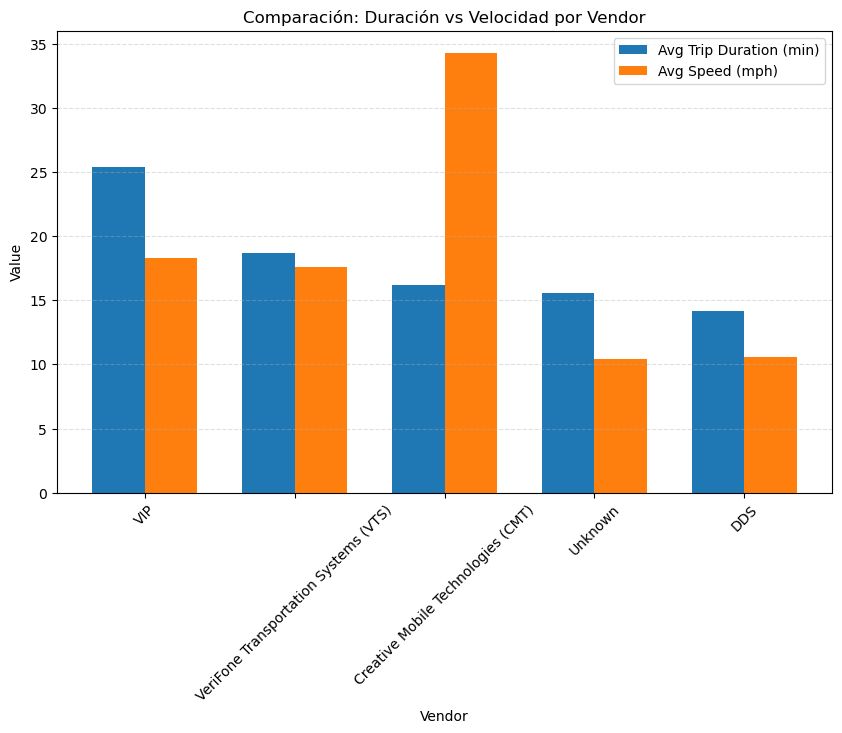

In [84]:
#o 
# Datos
vendors = df_vendor_metrics["VENDOR_NAME"]
durations = df_vendor_metrics["AVG_TRIP_DURATION"]
speeds = df_vendor_metrics["AVG_SPEED"]

# Posición para las barras
x = np.arange(len(vendors))
width = 0.35  # ancho de barra

# Crear figura
plt.figure(figsize=(10,6))

# Barras de duración
plt.bar(x - width/2, durations, width, label='Avg Trip Duration (min)')

# Barras de velocidad
plt.bar(x + width/2, speeds, width, label='Avg Speed (mph)')

# Etiquetas
plt.xlabel("Vendor")
plt.ylabel("Value")
plt.title("Comparación: Duración vs Velocidad por Vendor")
plt.xticks(x, vendors, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


In [85]:
# p. Relación método de pago ↔ tip_amount por hora. 
query = """
SELECT
    PAYMENT_TYPE_DESC,
    DATE_PART('HOUR', PICKUP_DATETIME) AS HOUR_OF_DAY,
    
    COUNT(*) AS TOTAL_TRIPS,
    ROUND(AVG(TIP_AMOUNT), 2) AS AVG_TIP_AMOUNT,
    
    -- Tip % sobre fare para medir generosidad real
    ROUND(
        AVG(
            CASE 
                WHEN FARE_AMOUNT > 0 THEN (TIP_AMOUNT / FARE_AMOUNT) * 100
                ELSE NULL
            END
        ), 2
    ) AS AVG_TIP_PCT
    
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY PAYMENT_TYPE_DESC, HOUR_OF_DAY
ORDER BY PAYMENT_TYPE_DESC, HOUR_OF_DAY;
"""

df_tip_payment = pd.read_sql(query, conn)
display(df_tip_payment.head(20))


/tmp/ipykernel_63114/3930270345.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tip_payment = pd.read_sql(query, conn)


,PAYMENT_TYPE_DESC,HOUR_OF_DAY,TOTAL_TRIPS,AVG_TIP_AMOUNT,AVG_TIP_PCT
0,Cash,0,7368327,0.0,0.0
1,Cash,1,5405967,0.0,0.0
2,Cash,2,3981583,0.0,0.0
3,Cash,3,3106543,0.0,0.0
4,Cash,4,2843876,0.0,0.0
5,Cash,5,2547893,0.0,0.0
6,Cash,6,4672081,0.0,0.0
7,Cash,7,6998705,0.0,0.0
8,Cash,8,8420484,0.0,0.0
9,Cash,9,9726318,0.0,0.0


In [87]:
query = """
SELECT
    PAYMENT_TYPE_DESC,
    DATE_PART('HOUR', PICKUP_DATETIME) AS HOUR_OF_DAY,
    
    ROUND(
        AVG(
            CASE 
                WHEN FARE_AMOUNT > 0 THEN (TIP_AMOUNT / FARE_AMOUNT) * 100
                ELSE NULL
            END
        ), 2
    ) AS AVG_TIP_PCT

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY PAYMENT_TYPE_DESC, HOUR_OF_DAY
ORDER BY PAYMENT_TYPE_DESC, HOUR_OF_DAY;
"""

df_tip_heatmap = pd.read_sql(query, conn)
display(df_tip_heatmap.head(20))


/tmp/ipykernel_63114/3033505993.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tip_heatmap = pd.read_sql(query, conn)


,PAYMENT_TYPE_DESC,HOUR_OF_DAY,AVG_TIP_PCT
0,Cash,0,0.0
1,Cash,1,0.0
2,Cash,2,0.0
3,Cash,3,0.0
4,Cash,4,0.0
5,Cash,5,0.0
6,Cash,6,0.0
7,Cash,7,0.0
8,Cash,8,0.0
9,Cash,9,0.0


In [88]:
#P

heatmap_data = df_tip_heatmap.pivot(
    index="PAYMENT_TYPE_DESC",
    columns="HOUR_OF_DAY",
    values="AVG_TIP_PCT"
)
display(heatmap_data)


HOUR_OF_DAY,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
PAYMENT_TYPE_DESC,,,,,,,,,,,,,,,,,,,,,
Cash,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Credit card,26.78,28.14,30.53,30.88,31.79,28.74,25.13,23.59,23.41,23.93,...,24.28,24.81,26.39,25.77,25.77,25.95,25.36,25.42,25.05,25.08
Dispute,0.11,0.06,0.07,0.18,0.04,0.02,0.04,0.07,0.12,0.16,...,0.07,0.08,0.06,0.07,0.10,0.04,0.09,0.05,0.05,0.07
No charge,0.03,0.06,0.16,0.03,0.03,0.01,0.02,0.09,0.06,0.10,...,0.06,0.05,0.06,0.08,0.04,0.02,0.10,0.05,0.03,0.08
Unknown,4.34,4.14,4.30,4.45,5.32,5.79,5.46,6.13,6.38,6.62,...,6.57,6.59,6.68,6.36,6.19,5.95,5.33,5.15,4.79,4.47


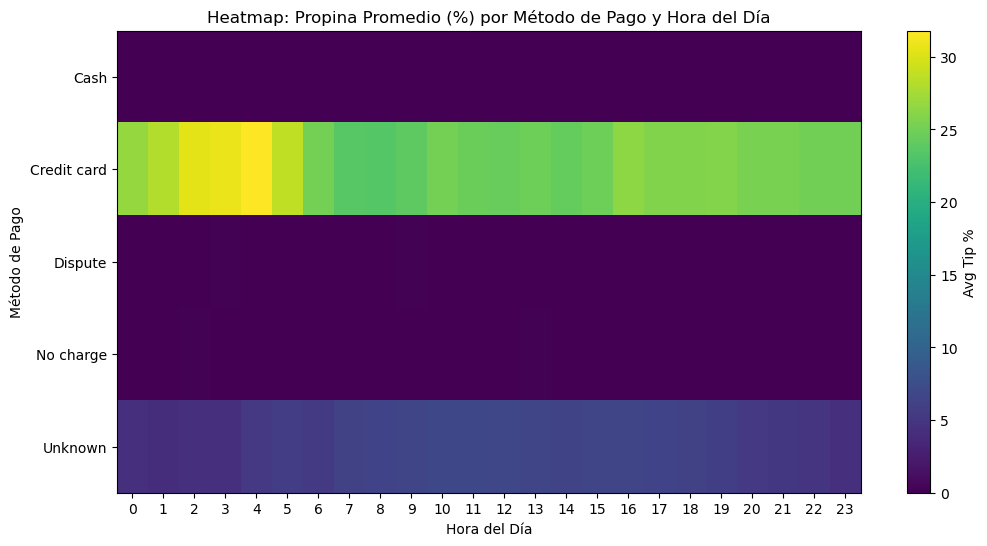

In [89]:
#P

plt.figure(figsize=(12, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis')
plt.colorbar(label='Avg Tip %')
plt.title("Heatmap: Propina Promedio (%) por Método de Pago y Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Método de Pago")
plt.xticks(range(24), range(24))
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

plt.show()


In [90]:
#q. Zonas con percentil 99 de duración/distancia fuera de rango (posible congestión/eventos).
query = """
SELECT
    PU_ZONE,
    PU_BOROUGH,
    
    PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY trip_duration_min) AS P99_DURATION_MIN,
    PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY trip_distance) AS P99_DISTANCE,

    COUNT(*) AS TOTAL_TRIPS
FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
GROUP BY PU_ZONE, PU_BOROUGH
HAVING P99_DURATION_MIN > 60  -- viajes > 1 hora
   OR P99_DISTANCE > 30       -- viajes > 30 millas
ORDER BY P99_DURATION_MIN DESC;
"""

df_p99_zones = pd.read_sql(query, conn)
display(df_p99_zones)


/tmp/ipykernel_63114/205894432.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_p99_zones = pd.read_sql(query, conn)


,PU_ZONE,PU_BOROUGH,P99_DURATION_MIN,P99_DISTANCE,TOTAL_TRIPS
0,Bronx Park,Bronx,215.000,21.9828,33287
1,Arden Heights,Staten Island,184.980,40.1854,2203
2,Coney Island,Brooklyn,172.000,29.8000,191582
3,Rossville/Woodrow,Staten Island,170.039,45.9738,367
4,Mariners Harbor,Staten Island,160.340,36.4217,4784
...,...,...,...,...,...
189,Steinway,Queens,61.000,14.9000,1513338
190,Elmhurst/Maspeth,Queens,61.000,13.9700,475867
191,Long Island City/Hunters Point,Queens,61.000,15.6400,1798428
192,Chinatown,Manhattan,61.000,16.7500,1432092


In [94]:
#r. Yield por milla (total_amount/trip_distance) por borough y hora. 
query = """
SELECT
    PU_BOROUGH AS BOROUGH,
    DATE_PART('HOUR', PICKUP_DATETIME) AS HOUR_OF_DAY,
    
    ROUND(AVG(total_amount / NULLIF(trip_distance, 0)), 2) AS AVG_YIELD_PER_MILE,
    COUNT(*) AS TOTAL_TRIPS

FROM ANALYTICS.OBT_TRIPS
WHERE YEAR BETWEEN 2015 AND 2025
  AND trip_distance > 0  AND TOTAL_AMOUNT < 1600-- evitamos divisiones por cero
GROUP BY PU_BOROUGH, HOUR_OF_DAY
ORDER BY BOROUGH, HOUR_OF_DAY;
"""

df_yield = pd.read_sql(query, conn)
display(df_yield.head(20))


/tmp/ipykernel_63114/3102957526.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yield = pd.read_sql(query, conn)


,BOROUGH,HOUR_OF_DAY,AVG_YIELD_PER_MILE,TOTAL_TRIPS
0,Bronx,0,13.45,131753
1,Bronx,1,15.21,96701
2,Bronx,2,16.55,68785
3,Bronx,3,15.01,58831
4,Bronx,4,13.25,72958
5,Bronx,5,12.24,90968
6,Bronx,6,11.51,154681
7,Bronx,7,11.08,253908
8,Bronx,8,11.81,315874
9,Bronx,9,11.83,294195


In [95]:
#r
heatmap_yield = df_yield.pivot(
    index="BOROUGH",
    columns="HOUR_OF_DAY",
    values="AVG_YIELD_PER_MILE"
)
display(heatmap_yield)


HOUR_OF_DAY,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
BOROUGH,,,,,,,,,,,,,,,,,,,,,
Bronx,13.45,15.21,16.55,15.01,13.25,12.24,11.51,11.08,11.81,11.83,...,11.81,12.40,16.19,17.73,16.63,15.42,13.42,12.91,12.44,12.82
Brooklyn,8.26,8.40,8.55,9.23,9.50,8.97,7.43,8.03,8.65,9.03,...,9.94,10.34,14.50,14.92,14.11,12.07,9.31,9.17,8.62,8.44
EWR,661.68,590.93,623.99,1080.89,1558.86,1455.83,1737.38,1476.51,1473.93,1516.29,...,1617.14,1649.79,1612.27,1740.94,1709.66,1474.73,1268.06,741.17,727.46,694.60
Manhattan,8.98,8.79,8.57,8.36,8.12,8.07,8.11,8.83,9.87,10.28,...,10.73,10.99,13.39,13.34,13.08,11.81,9.71,9.43,9.24,9.12
N/A,242.35,237.89,260.68,241.66,191.52,100.44,47.10,54.06,66.36,73.46,...,74.19,85.62,83.86,111.47,129.84,174.49,184.00,184.16,217.34,225.73
Queens,7.70,8.50,9.27,10.26,14.14,19.21,14.50,11.78,10.80,10.81,...,13.03,14.49,15.72,14.08,13.06,11.09,8.28,7.78,7.55,7.47
Staten Island,42.52,66.71,65.91,86.72,69.34,35.49,12.33,11.68,17.68,23.29,...,29.07,27.87,32.08,44.21,45.46,39.24,36.73,59.40,79.42,79.99
Unknown,25.24,25.98,24.65,30.59,45.38,58.32,35.02,26.55,26.10,26.57,...,30.56,33.32,35.05,30.53,26.90,24.58,22.30,22.28,21.93,23.80


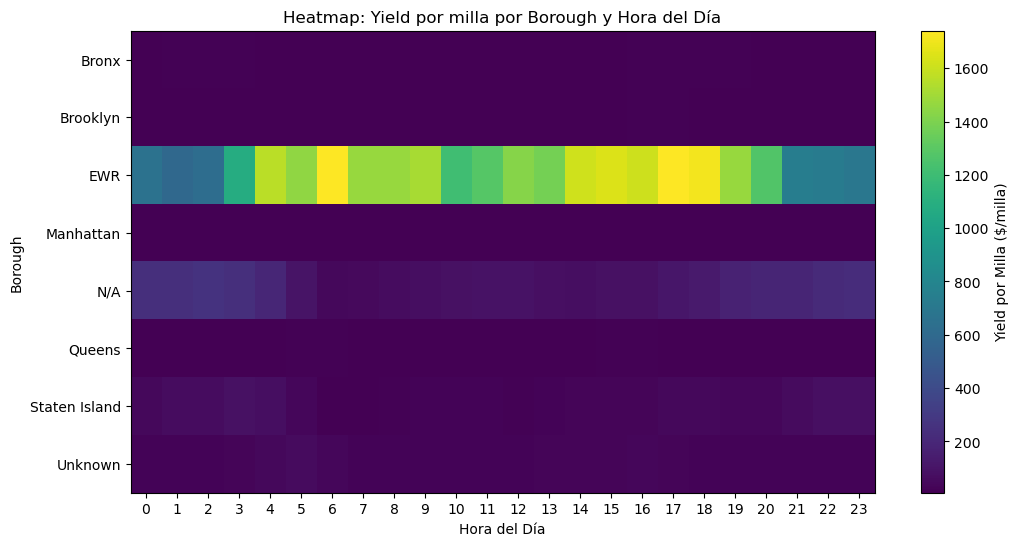

In [96]:
#r
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_yield, aspect='auto', cmap='viridis')
plt.colorbar(label='Yield por Milla ($/milla)')
plt.title("Heatmap: Yield por milla por Borough y Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Borough")
plt.xticks(range(24), range(24))
plt.yticks(range(len(heatmap_yield.index)), heatmap_yield.index)
plt.show()


In [105]:
#s. Cambios YoY en volumen y ticket promedio por service_type. 
query = """
WITH yearly_metrics AS (
    SELECT
        YEAR,
        SERVICE_TYPE,
        COUNT(*) AS TOTAL_TRIPS,
        ROUND(AVG(TOTAL_AMOUNT), 2) AS AVG_TICKET
    FROM ANALYTICS.OBT_TRIPS
    WHERE YEAR BETWEEN 2015 AND 2025
    GROUP BY YEAR, SERVICE_TYPE
)

SELECT
    YEAR,
    SERVICE_TYPE,
    TOTAL_TRIPS,
    AVG_TICKET,
    
    -- Variación porcentual YoY en volumen
    ROUND(
        (TOTAL_TRIPS - LAG(TOTAL_TRIPS) OVER (PARTITION BY SERVICE_TYPE ORDER BY YEAR))
        / NULLIF(LAG(TOTAL_TRIPS) OVER (PARTITION BY SERVICE_TYPE ORDER BY YEAR), 0) * 100,
        2
    ) AS YOY_TRIPS_PCT,
    
    -- Variación porcentual YoY en ticket promedio
    ROUND(
        (AVG_TICKET - LAG(AVG_TICKET) OVER (PARTITION BY SERVICE_TYPE ORDER BY YEAR))
        / NULLIF(LAG(AVG_TICKET) OVER (PARTITION BY SERVICE_TYPE ORDER BY YEAR), 0) * 100,
        2
    ) AS YOY_TICKET_PCT

FROM yearly_metrics
ORDER BY SERVICE_TYPE, YEAR;
"""

df_yoy = pd.read_sql(query, conn)
display(df_yoy)


/tmp/ipykernel_63114/2348656920.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yoy = pd.read_sql(query, conn)


,YEAR,SERVICE_TYPE,TOTAL_TRIPS,AVG_TICKET,YOY_TRIPS_PCT,YOY_TICKET_PCT
10,2025,GREEN,397923,24.85,-39.73,2.43
11,2015,YELLOW,133298197,16.19,NaN,NaN
12,2016,YELLOW,131131805,16.38,-1.63,1.17
13,2017,YELLOW,47442646,16.12,-63.82,-1.59
14,2018,YELLOW,102870524,16.43,116.83,1.92
15,2019,YELLOW,84597309,19.19,-17.76,16.80
16,2020,YELLOW,24649266,18.42,-70.86,-4.01
17,2021,YELLOW,30903983,19.70,25.37,6.95
18,2022,YELLOW,39655622,21.67,28.32,10.00
19,2023,YELLOW,38310138,28.46,-3.39,31.33


In [106]:
#t. Días con alta congestion_surcharge: efecto en total_amount vs días “normales”
query = """
WITH daily_metrics AS (
    SELECT
        TO_DATE(pickup_datetime) AS trip_date,
        SUM(congestion_surcharge) AS total_congestion,
        AVG(total_amount) AS avg_total_amount
    FROM ANALYTICS.OBT_TRIPS
    GROUP BY TO_DATE(pickup_datetime)
),

classified_days AS (
    SELECT
        trip_date,
        avg_total_amount,
        CASE 
            WHEN total_congestion > 10000 THEN 'High Congestion Day'
            ELSE 'Normal Day'
        END AS day_type
    FROM daily_metrics
)

SELECT
    day_type,
    ROUND(AVG(avg_total_amount), 2) AS overall_avg_ticket
FROM classified_days
GROUP BY day_type;

"""
df_t = pd.read_sql(query, conn)
display(df_t)

/tmp/ipykernel_63114/2577288938.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql(query, conn)


,DAY_TYPE,OVERALL_AVG_TICKET
0,High Congestion Day,22.93
1,Normal Day,16.17
